In [231]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import  VarianceThreshold

In [47]:
# issues
# ------
# unbanced class target , 19 classes
# all categorical features
# ` ?` represent missing values: fill ` ?` with `Unk`

# dummy variables all categorical features

In [136]:
data = (pd.read_csv('data/dataset_42_soybean.csv')
            .applymap(str.strip)            # remove unnecessary white spaces
            .replace('?', np.nan)           # correct missing values with nan (for EDA)
       )

data.head().T

,0,1,2,3,4
date,october,august,july,july,october
plant-stand,normal,normal,normal,normal,normal
precip,gt-norm,gt-norm,gt-norm,gt-norm,gt-norm
temp,norm,norm,norm,norm,norm
hail,yes,yes,yes,yes,yes
crop-hist,same-lst-yr,same-lst-two-yrs,same-lst-yr,same-lst-yr,same-lst-two-yrs
area-damaged,low-areas,scattered,scattered,scattered,scattered
severity,pot-severe,severe,severe,severe,pot-severe
seed-tmt,none,fungicide,fungicide,none,none
germination,90-100,80-89,lt-80,80-89,lt-80


In [115]:
for col in data.columns[:-2]:
    print('='*30)
    print('columns: {}'.format(col))
    print('='*30)
    print(data[col].value_counts(dropna=False))
    print('#'*30)
    print()

columns: date
september    149
august       131
july         118
june          93
october       90
may           75
april         26
NaN            1
Name: date, dtype: int64
##############################

columns: plant-stand
normal       354
lt-normal    293
NaN           36
Name: plant-stand, dtype: int64
##############################

columns: precip
gt-norm    459
norm       112
lt-norm     74
NaN         38
Name: precip, dtype: int64
##############################

columns: temp
norm       374
gt-norm    199
lt-norm     80
NaN         30
Name: temp, dtype: int64
##############################

columns: hail
yes    435
no     127
NaN    121
Name: hail, dtype: int64
##############################

columns: crop-hist
same-lst-two-yrs    219
same-lst-sev-yrs    218
same-lst-yr         165
diff-lst-year        65
NaN                  16
Name: crop-hist, dtype: int64
##############################

columns: area-damaged
low-areas      227
whole-field    187
upper-areas    145
scatter

In [119]:
ordinal_cols = ['plant-stand', 'precip', 'temp', 'germination', 'seed-size']
nominal_cols = ['date', 'hail', 'crop-hist', 'area-damaged', 'severity',
                'seed-tmt', 'plant-growth', 'leaves', 'leafspots-halo',
                'leafspots-marg', 'leafspot-size', 'leaf-shread', 'leaf-malf',
                'leaf-mild', 'stem', 'lodging', 'stem-cankers', 'canker-lesion',
                'fruiting-bodies', 'external-decay', 'mycelium', 'int-discolor',
                'sclerotia', 'fruit-pods', 'fruit-spots', 'seed', 'mold-growth',
                'seed-discolor', 'shriveling', 'roots']

len(ordinal_cols) + len(nominal_cols)

35

In [122]:
for col in ordinal_cols:
    print('='*30)
    print('columns: {}'.format(col))
    print('='*30)
    print(data[col].value_counts(dropna=False))
    print('#'*30)
    print()

columns: plant-stand
normal       354
lt-normal    293
NaN           36
Name: plant-stand, dtype: int64
##############################

columns: precip
gt-norm    459
norm       112
lt-norm     74
NaN         38
Name: precip, dtype: int64
##############################

columns: temp
norm       374
gt-norm    199
lt-norm     80
NaN         30
Name: temp, dtype: int64
##############################

columns: germination
80-89     213
lt-80     193
90-100    165
NaN       112
Name: germination, dtype: int64
##############################

columns: seed-size
norm       532
NaN         92
lt-norm     59
Name: seed-size, dtype: int64
##############################



In [157]:
categories = [
    ['UNK','lt-normal', 'normal'], # plant-stand
    ['UNK','lt-norm', 'norm', 'gt-norm'], # precip
    ['UNK','lt-norm', 'norm', 'gt-norm'], # temp
    ['UNK','lt-80', '80-89', '90-100'], # germination
    ['UNK','lt-norm', 'norm'], # seed-size
]

ordinal_imputer = SimpleImputer(strategy='constant', fill_value='UNK')
ordinal_encoder = OrdinalEncoder(categories=categories)
ordinal_encoder.handle_unknown = 'ignore'   # OrdinalEncoder bug: asking for handle_unknown attribute
ordinal_transformer = make_pipeline(ordinal_imputer, ordinal_encoder)

In [158]:
data_ordinal_trans = pd.DataFrame(ordinal_transformer.fit_transform(data[ordinal_cols]), 
                                  columns=ordinal_cols)

In [154]:
data_ordinal_trans

,plant-stand,precip,temp,germination,seed-size
0,2.0,3.0,2.0,3.0,2.0
1,2.0,3.0,2.0,2.0,2.0
2,2.0,3.0,2.0,1.0,2.0
3,2.0,3.0,2.0,2.0,2.0
4,2.0,3.0,2.0,1.0,2.0
5,2.0,3.0,2.0,2.0,2.0
6,2.0,3.0,2.0,3.0,2.0
7,2.0,3.0,2.0,1.0,2.0
8,2.0,3.0,2.0,2.0,2.0
9,2.0,3.0,2.0,1.0,2.0


In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 36 columns):
date               682 non-null object
plant-stand        647 non-null object
precip             645 non-null object
temp               653 non-null object
hail               562 non-null object
crop-hist          667 non-null object
area-damaged       682 non-null object
severity           562 non-null object
seed-tmt           562 non-null object
germination        571 non-null object
plant-growth       667 non-null object
leaves             683 non-null object
leafspots-halo     599 non-null object
leafspots-marg     599 non-null object
leafspot-size      599 non-null object
leaf-shread        583 non-null object
leaf-malf          599 non-null object
leaf-mild          575 non-null object
stem               667 non-null object
lodging            562 non-null object
stem-cankers       645 non-null object
canker-lesion      645 non-null object
fruiting-bodies    577 non-null objec

In [50]:
# distribution of unique values in each columns
data.nunique().value_counts(dropna=False)

2     16
3     12
4      6
19     1
7      1
dtype: int64

In [51]:
# number of missing values by columns
# note that some columns share the same number of missing values
# could mean some pattern of missing between samples
data.isnull().sum()

date                 1
plant-stand         36
precip              38
temp                30
hail               121
crop-hist           16
area-damaged         1
severity           121
seed-tmt           121
germination        112
plant-growth        16
leaves               0
leafspots-halo      84
leafspots-marg      84
leafspot-size       84
leaf-shread        100
leaf-malf           84
leaf-mild          108
stem                16
lodging            121
stem-cankers        38
canker-lesion       38
fruiting-bodies    106
external-decay      38
mycelium            38
int-discolor        38
sclerotia           38
fruit-pods          84
fruit-spots        106
seed                92
mold-growth         92
seed-discolor      106
seed-size           92
shriveling         106
roots               31
class                0
dtype: int64

In [64]:
# percent missing in each column
data.isnull().sum() / len(data) * 100

date                      0.146413
plant-stand               5.270864
precip                    5.563690
temp                      4.392387
hail                     17.715959
crop-hist                 2.342606
area-damaged              0.146413
severity                 17.715959
seed-tmt                 17.715959
germination              16.398243
plant-growth              2.342606
leaves                    0.000000
leafspots-halo           12.298682
leafspots-marg           12.298682
leafspot-size            12.298682
leaf-shread              14.641288
leaf-malf                12.298682
leaf-mild                15.812592
stem                      2.342606
lodging                  17.715959
stem-cankers              5.563690
canker-lesion             5.563690
fruiting-bodies          15.519766
external-decay            5.563690
mycelium                  5.563690
int-discolor              5.563690
sclerotia                 5.563690
fruit-pods               12.298682
fruit-spots         

In [52]:
data.isnull().sum().sum() / np.prod(data.shape)

0.09504636408003904

In [55]:
# create a new feature: missing values info
data['total_missing_columns'] = data.isnull().sum(axis=1).values

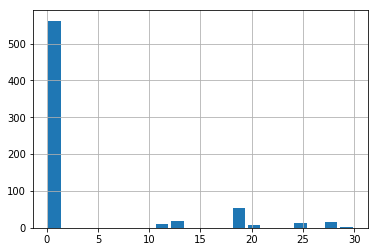

In [56]:
data['total_missing_columns'].hist(bins=20, rwidth=.8)

In [57]:
# different target distribution among each group by number of missing columns
# plan -> try onehot encoding for each missing group
for val in data.total_missing_columns.unique():
    print('='*30)
    print("{} missing columns group".format(val))
    print('='*30)
    print(data.query('total_missing_columns=={}'.format(val))
              ['class']
              .value_counts()
         )
    print('#'*30)
    print() 

0 missing columns group
brown-spot                92
alternarialeaf-spot       91
frog-eye-leaf-spot        91
anthracnose               44
brown-stem-rot            44
powdery-mildew            20
downy-mildew              20
phyllosticta-leaf-spot    20
diaporthe-stem-canker     20
charcoal-rot              20
phytophthora-rot          20
purple-seed-stain         20
rhizoctonia-root-rot      20
bacterial-pustule         20
bacterial-blight          20
Name: class, dtype: int64
##############################

13 missing columns group
phytophthora-rot               13
diaporthe-pod-&-stem-blight     6
Name: class, dtype: int64
##############################

19 missing columns group
phytophthora-rot    55
Name: class, dtype: int64
##############################

11 missing columns group
diaporthe-pod-&-stem-blight    9
Name: class, dtype: int64
##############################

24 missing columns group
cyst-nematode    14
Name: class, dtype: int64
##############################

30 miss

In [58]:
# disbribution of the target variable
# It shows very unbalanced distribution 
data['class'].value_counts()

brown-spot                     92
frog-eye-leaf-spot             91
alternarialeaf-spot            91
phytophthora-rot               88
brown-stem-rot                 44
anthracnose                    44
charcoal-rot                   20
diaporthe-stem-canker          20
bacterial-pustule              20
powdery-mildew                 20
bacterial-blight               20
downy-mildew                   20
purple-seed-stain              20
rhizoctonia-root-rot           20
phyllosticta-leaf-spot         20
2-4-d-injury                   16
diaporthe-pod-&-stem-blight    15
cyst-nematode                  14
herbicide-injury                8
Name: class, dtype: int64

In [59]:
data.describe(include=['O']).T

,count,unique,top,freq
date,682,7,september,149
plant-stand,647,2,normal,354
precip,645,3,gt-norm,459
temp,653,3,norm,374
hail,562,2,yes,435
crop-hist,667,4,same-lst-two-yrs,219
area-damaged,682,4,low-areas,227
severity,562,3,pot-severe,322
seed-tmt,562,3,none,305
germination,571,3,80-89,213


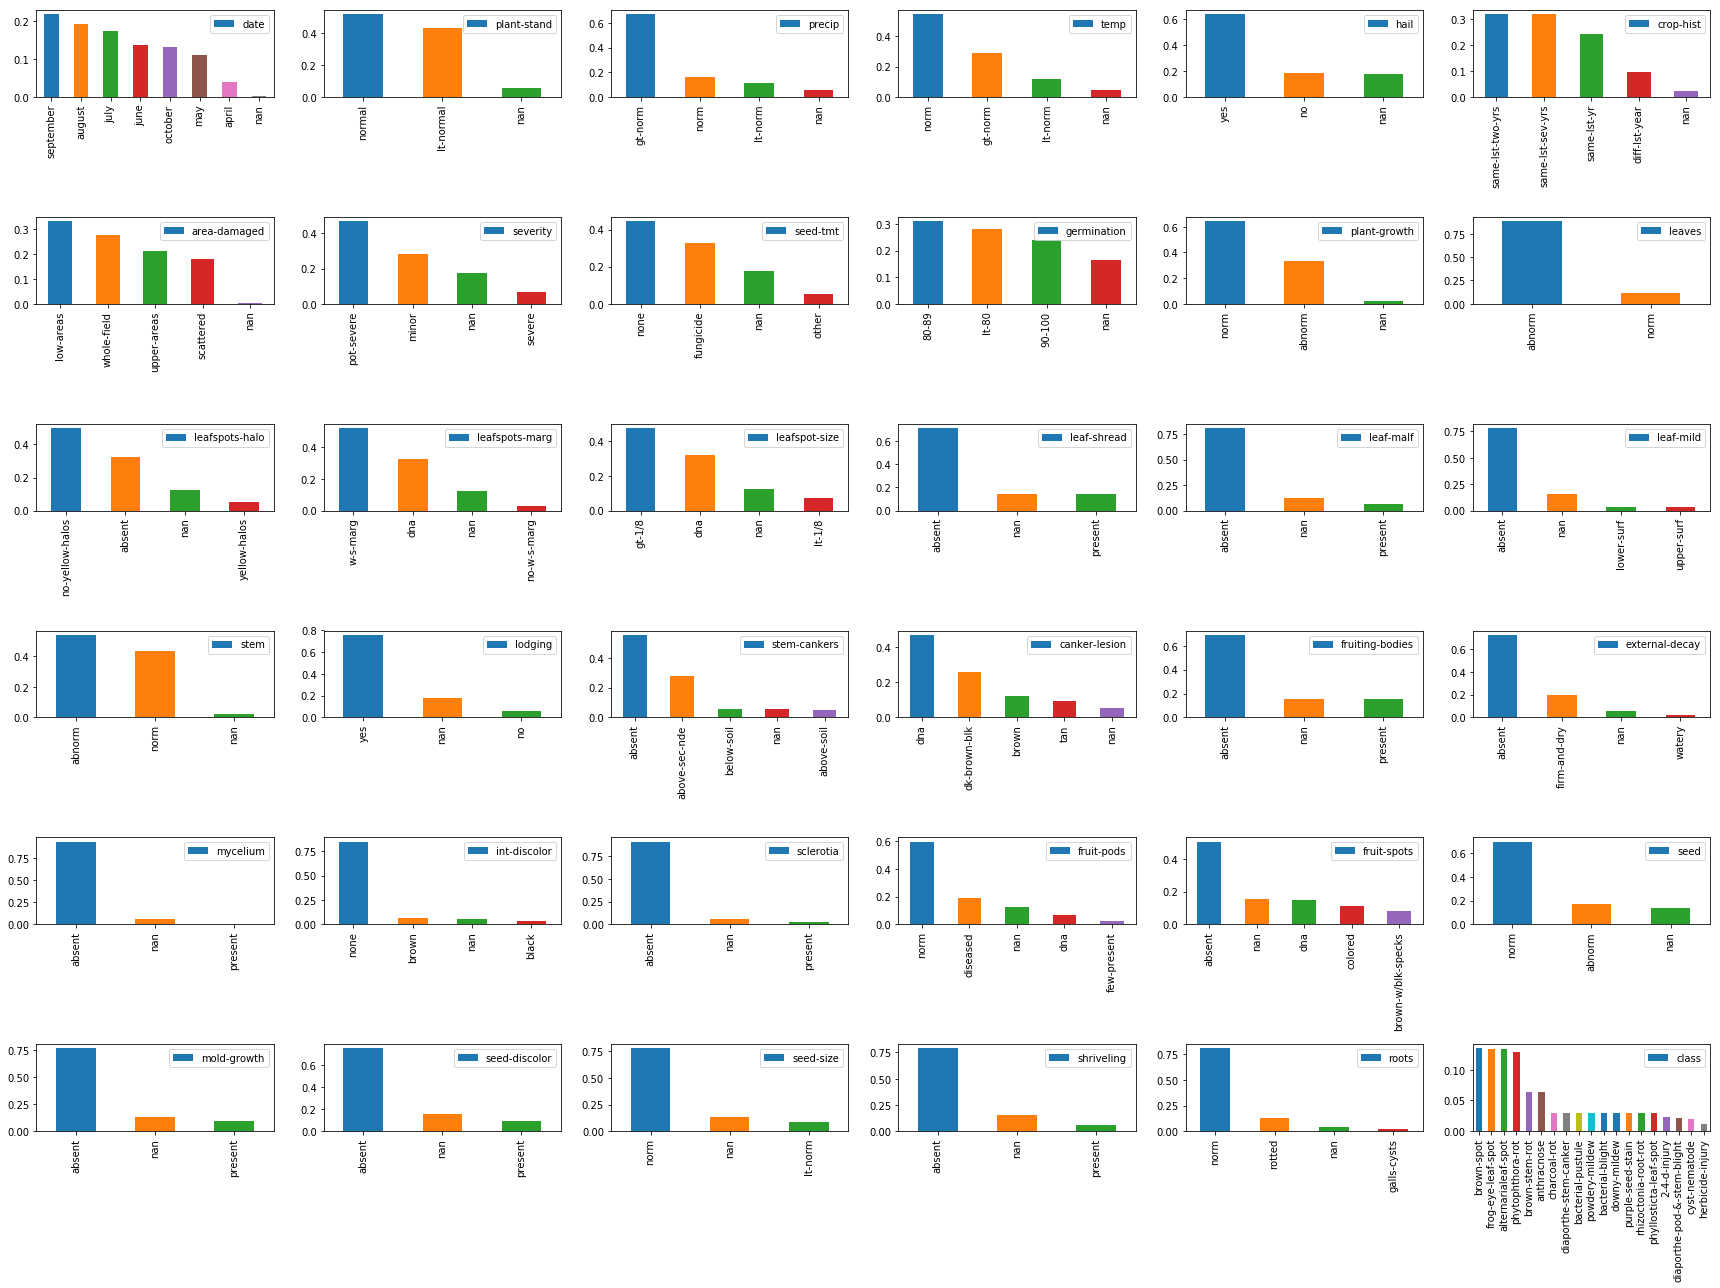

In [60]:
n = data.shape[1]
fig, axs = plt.subplots(nrows=6, ncols=6, figsize=(24, 18))

for ax, col in zip(axs.flat, data.columns):
    data[col].value_counts(normalize=True, dropna=False).plot.bar(ax=ax)
    ax.legend([col], loc='best')
    
fig.tight_layout()

In [67]:
data_ohe = pd.get_dummies((data
                               .drop('class', axis=1)
                               .assign(total_missing_columns=data.total_missing_columns.astype(str))
                          ))

In [68]:
data_ohe.head()

,date_april,date_august,date_july,date_june,date_may,date_october,date_september,plant-stand_lt-normal,plant-stand_normal,precip_gt-norm,...,roots_norm,roots_rotted,total_missing_columns_0,total_missing_columns_11,total_missing_columns_13,total_missing_columns_19,total_missing_columns_20,total_missing_columns_24,total_missing_columns_28,total_missing_columns_30
0,0,0,0,0,0,1,0,0,1,1,...,1,0,1,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,1,...,1,0,1,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,1,1,...,1,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,1,1,...,1,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,1,...,1,0,1,0,0,0,0,0,0,0


In [70]:
X = data_ohe
y = data['class']

In [71]:
rf = RandomForestClassifier(n_estimators=100)

In [72]:
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

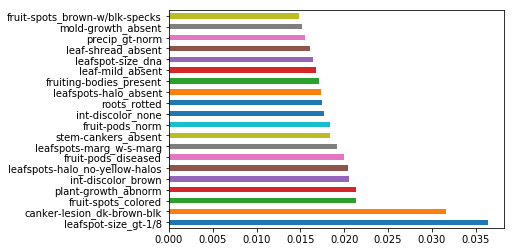

In [77]:
(pd.Series(rf.feature_importances_, index=data_ohe.columns)
     .sort_values(ascending=False)
     .head(20)
     .plot
     .barh()
)

In [80]:
scores = cross_val_score(rf, X, y, cv=5)

In [81]:
scores.mean(), scores.std()

(0.928625172613572, 0.03279100255184548)

In [92]:
lr = LogisticRegression(penalty='l1', solver='saga', class_weight='balanced',
                        multi_class='multinomial', max_iter=500)
scores = cross_val_score(lr, X, y, cv=5)

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converg

In [94]:
scores.std(), scores.mean()

(0.039975872619965505, 0.9258665886215397)

In [95]:
lr.fit(X, y)

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='multinomial', n_jobs=None, penalty='l1',
          random_state=None, solver='saga', tol=0.0001, verbose=0,
          warm_start=False)

In [102]:
a = pd.Series(lr.coef_.mean(axis=0), index=data_ohe.columns)

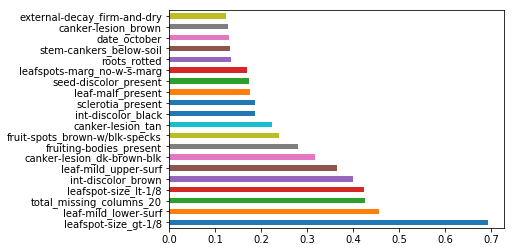

In [109]:
a.iloc[np.argsort(a.abs().values)[::-1]].head(20).plot.barh()

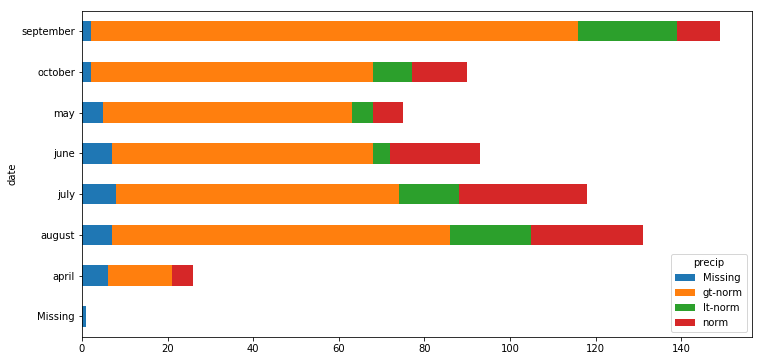

In [169]:
(data
     .fillna('Missing')
     .groupby(['date', 'precip'])
     ['precip']
     .count()
     .unstack()
     .fillna(0)
     .plot
     .barh(stacked=True, figsize=(12, 6))
)

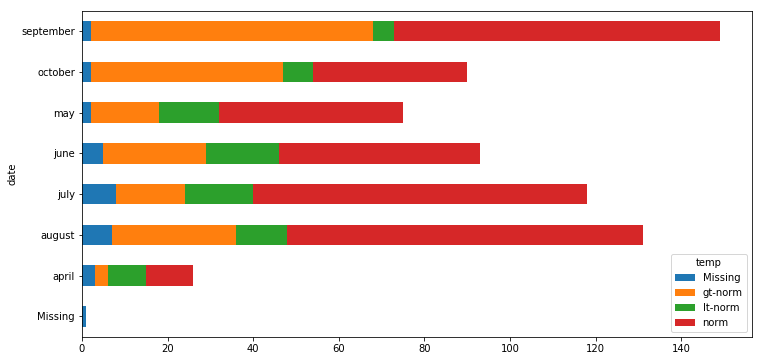

In [171]:
(data
     .fillna('Missing')
     .groupby(['date', 'temp'])
     ['temp']
     .count()
     .unstack()
     #.fillna(0)
     .plot
     .barh(stacked=True, figsize=(12, 6))
)

In [175]:
data.isnull().groupby(data['class']).sum()

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,sclerotia,fruit-pods,fruit-spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots,class
class,,,,,,,,,,,,,,,,,,,,,
2-4-d-injury,1.0,16.0,16.0,16.0,16.0,16.0,1.0,16.0,16.0,16.0,...,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,0.0
alternarialeaf-spot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
anthracnose,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bacterial-blight,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bacterial-pustule,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
brown-spot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
brown-stem-rot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
charcoal-rot,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
cyst-nematode,0.0,14.0,14.0,14.0,14.0,0.0,0.0,14.0,14.0,14.0,...,14.0,0.0,14.0,0.0,0.0,14.0,0.0,14.0,0.0,0.0


In [189]:
data.isnull().groupby('class').mean()

,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,germination,...,int-discolor,sclerotia,fruit-pods,fruit-spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots
class,,,,,,,,,,,,,,,,,,,,,
False,0.001464,0.052709,0.055637,0.043924,0.17716,0.023426,0.001464,0.17716,0.17716,0.163982,...,0.055637,0.055637,0.122987,0.155198,0.1347,0.1347,0.155198,0.1347,0.155198,0.045388


In [191]:
data.isnull().sum()

date                 1
plant-stand         36
precip              38
temp                30
hail               121
crop-hist           16
area-damaged         1
severity           121
seed-tmt           121
germination        112
plant-growth        16
leaves               0
leafspots-halo      84
leafspots-marg      84
leafspot-size       84
leaf-shread        100
leaf-malf           84
leaf-mild          108
stem                16
lodging            121
stem-cankers        38
canker-lesion       38
fruiting-bodies    106
external-decay      38
mycelium            38
int-discolor        38
sclerotia           38
fruit-pods          84
fruit-spots        106
seed                92
mold-growth         92
seed-discolor      106
seed-size           92
shriveling         106
roots               31
class                0
dtype: int64

In [196]:
data_dummy = pd.get_dummies(data.fillna('UNK'))
data_dummy.shape

(683, 152)

In [207]:
zerovar = VarianceThreshold(.05)

In [208]:
zerovar.fit_transform(data_dummy).shape

(683, 118)

In [210]:
1 - 118/152

0.22368421052631582

In [221]:
scores = cross_val_score(RandomForestClassifier(n_estimators=10), data_dummy, y, cv=5)

In [222]:
scores.mean(), scores.std()

(0.9940957015409569, 0.008634845715182504)

In [223]:
scores

array([1.        , 1.        , 0.99270073, 0.97777778, 1.        ])

In [224]:
rf = RandomForestClassifier(n_estimators=10).fit(data_dummy, y)

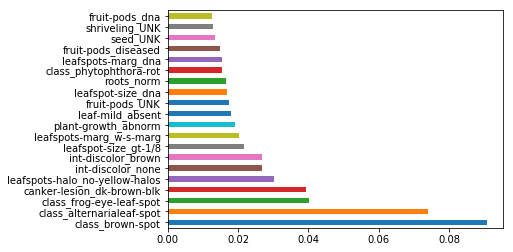

In [227]:
(pd.Series(rf.feature_importances_, index=data_dummy.columns)
     .sort_values(ascending=False)
     .head(20)
     .plot
     .barh()
)

In [245]:
k4 = StratifiedKFold(n_splits=4, random_state=42)

rf_pipe = make_pipeline(
    #SimpleImputer(strategy='constant', fill_value='UNK'),
    #OneHotEncoder(),
    VarianceThreshold(threshold=0.0),
    RandomForestClassifier(n_estimators=10)
)

rf_params = {
        'variancethreshold__threshold': [0., 0.01, 0.05, 0.1],
        'randomforestclassifier__n_estimators': [10, 20]
}

In [246]:
rf_grid = GridSearchCV(rf_pipe, rf_params, cv=k4, 
                       scoring='accuracy', verbose=2, n_jobs=2)

In [247]:
rf_grid.fit(data_dummy, data['class'])

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  32 out of  32 | elapsed:    6.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=42, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('variancethreshold', VarianceThreshold(threshold=0.0)), ('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'randomforestclassifier__n_estimators': [10, 20], 'variancethreshold__threshold': [0.0, 0.01, 0.05, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [248]:
rf_grid.best_score_, rf_grid.best_params_

(1.0,
 {'randomforestclassifier__n_estimators': 20,
  'variancethreshold__threshold': 0.05})

In [249]:
rf_grid.cv_results_['mean_test_score']

array([0.99853587, 0.99560761, 0.98389458, 0.98682284, 0.99853587,
       0.99853587, 1.        , 0.99560761])